In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

import pickle
import os

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Getting Dataset

In [3]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data', download= True, train = True, transform = transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST(root='./data', download= True, train = False, transform = transforms.Compose([transforms.ToTensor()]))

## Making the data 3d and 224x224

In [4]:
import torch.nn.functional as F
import numpy as np
from scipy.ndimage import zoom

length = len(train_dataset.data)
train_data = []

for x in range(length):

    test, target = train_dataset.__getitem__(x)
    
    test = test.unsqueeze(0)
    
    desired_shape = (224, 224)
    resized_image = F.interpolate(test, size=desired_shape, mode='bilinear', align_corners=False)
    
    resized_image = resized_image.squeeze(0).squeeze(0)
    resized_image = resized_image.numpy()

    new_image = np.array([resized_image,resized_image,resized_image])
    new_image = torch.tensor(new_image)
    
    train_data.insert(x, [new_image, target])

length = len(test_dataset.data)
test_data = []

for x in range(length):

    test, target = test_dataset.__getitem__(x)
    
    test = test.unsqueeze(0)
    
    desired_shape = (224, 224)
    resized_image = F.interpolate(test, size=desired_shape, mode='bilinear', align_corners=False)
    
    resized_image = resized_image.squeeze(0).squeeze(0)
    resized_image = resized_image.numpy()

    new_image = np.array([resized_image,resized_image,resized_image])
    new_image = torch.tensor(new_image)
    
    test_data.insert(x, [new_image, target])

In [5]:
# FOR DUMPING OUT THE 3D TENSORS

# file_name = '3d_224_train.pkl' 

# with open(os.getcwd() + '/data/pickle_out/' + file_name, 'wb') as file:
#     pickle.dump(new_data, file)

In [6]:
from utils import FashionMnist_Dataset

train_dataset = FashionMnist_Dataset(train_data)
test_dataset = FashionMnist_Dataset(test_data)

BATCH_SIZE = 128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [15]:
from utils import train_loop, test_loop, EarlyStopper
from pretrained_model import inceptionNet_pretrained

num_epochs = 60
lr = 0.001
patience = 5

early_stopper = EarlyStopper(patience=patience, min_delta=0)
model = inceptionNet_pretrained(train_last_layer_only= False)
model.to(device= device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

tr_acc, te_acc = [], []
tr_loss, te_loss = [], []

best_acc = 0

for epoch in range(num_epochs):
    train_loss, train_correct = train_loop(train_loader, model, loss_fn, optimizer, device)
    test_loss, test_correct = test_loop(test_loader, model, loss_fn, device)

    print('Train Acc epoch {} : {} '.format(epoch, train_correct))
    print('Test Acc epoch {} : {} '.format(epoch, test_correct))

    tr_acc.append(train_correct)
    te_acc.append(test_correct)

    tr_loss.append(train_loss)
    te_loss.append(test_loss)

    if early_stopper.early_stop(test_loss):
        print("Done! Early stopped at {}".format(epoch))
        break



Using cache found in C:\Users\ianch/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\ianch\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ianch\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\ianch\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResiz

RuntimeError: Calculated padded input size per channel: (3 x 3). Kernel size: (5 x 5). Kernel size can't be greater than actual input size

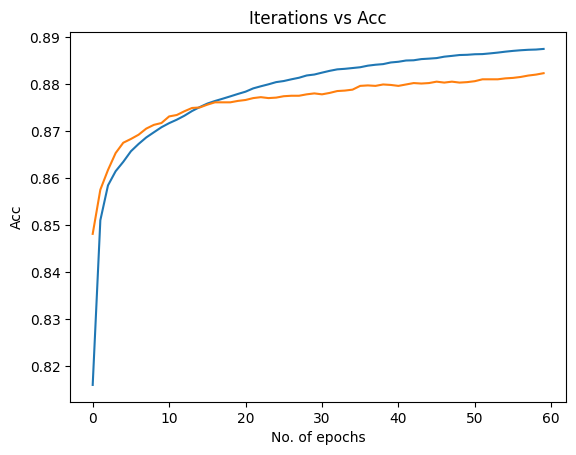

In [10]:
plt.plot(range(epoch+1), tr_acc)
plt.plot(range(epoch+1), te_acc)
plt.xlabel("No. of epochs")
plt.ylabel("Acc")
plt.title("Iterations vs Acc")
plt.show()

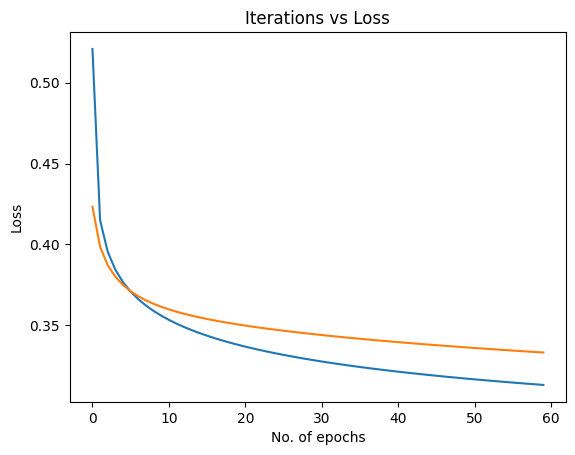

In [11]:
plt.plot(range(epoch+1), tr_loss)
plt.plot(range(epoch+1), te_loss)
plt.xlabel("No. of epochs")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

In [12]:
print("Best Acc : {} | Best Epoch : {}".format(max(te_acc), te_acc.index(max(te_acc))))

Best Acc : 0.8824 | Best Epoch : 59


## Pickle out results and accuracies

In [13]:
import pickle
import os

file_name = 'pretrained_inceptionnet_freeze.pkl' 

with open(os.getcwd() + '/results/' + file_name, 'wb') as file:
    pickle.dump(tr_acc, file)
    pickle.dump(te_acc, file)
    pickle.dump(tr_loss, file)
    pickle.dump(te_loss, file)

## Pickle in results and accuracies

In [14]:
file_name = 'pretrained_inceptionnet_freeze.pkl' 

with open(os.getcwd() + '/results/' + file_name, 'rb') as file:
    tr_acc = pickle.load(file)
    te_acc = pickle.load(file)
    tr_loss = pickle.load(file)
    te_loss = pickle.load(file)


print(tr_acc)
print(te_acc)
print(tr_loss)
print(te_loss)

[0.81605, 0.8511, 0.8585166666666667, 0.8615333333333334, 0.8635333333333334, 0.8657833333333333, 0.8673333333333333, 0.8687166666666667, 0.8698166666666667, 0.8709, 0.8717666666666667, 0.8725, 0.87335, 0.87435, 0.8751833333333333, 0.8759333333333333, 0.8764833333333333, 0.8769666666666667, 0.8774666666666666, 0.8779833333333333, 0.8784666666666666, 0.8791666666666667, 0.8796166666666667, 0.8800333333333333, 0.8805, 0.8807333333333334, 0.8811, 0.8814333333333333, 0.8819166666666667, 0.8821166666666667, 0.8825166666666666, 0.8829, 0.8832166666666666, 0.8833333333333333, 0.8835, 0.8836666666666667, 0.884, 0.8842, 0.8843333333333333, 0.8846833333333334, 0.8848333333333334, 0.8851, 0.88515, 0.8854, 0.8855, 0.8856166666666667, 0.8859166666666667, 0.8860833333333333, 0.8862666666666666, 0.8863166666666666, 0.8864333333333333, 0.8864666666666666, 0.8866166666666667, 0.8867833333333334, 0.8869833333333333, 0.88715, 0.8872833333333333, 0.8873833333333333, 0.8874333333333333, 0.8875666666666666]